In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import re 

In [11]:
fields = [
    "HourlyWindSpeed",
    "HourlyWindDirection",
    "HourlyWindGustSpeed",
    "HourlyDryBulbTemperature",
    "HourlyDewPointTemperature",
    "HourlyRelativeHumidity",
    "HourlySeaLevelPressure",
    "HourlyVisibility",
    "HourlyPrecipitation",
    "HourlyPresentWeatherType",
    "HourlySkyConditions",
    'DATE'
]

# Loading pre-downloaded NOAA dataset from the meteo station at SDF airport
df = pd.read_csv("data/724230-93821.csv", usecols=fields)
df.head()

C:\Users\Desmo\AppData\Local\Temp\ipykernel_11088\3440379342.py:17: DtypeWarning: Columns (10,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/724230-93821.csv", usecols=fields)


,DATE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyVisibility,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed
0,2024-01-01T00:56:00,25.0,34.0,0.00,NaN,70.0,SCT:04 25 BKN:07 50,30.15,10.00,270,NaN,10.0
1,2024-01-01T01:00:00,25.0,34.0,NaN,NaN,70.0,26,30.15,9.94,270,NaN,10.0
2,2024-01-01T01:56:00,25.0,34.0,0.00,NaN,70.0,OVC:08 45,30.16,10.00,290,NaN,11.0
3,2024-01-01T02:20:00,25.0,34.0,NaN,NaN,70.0,FEW:02 15 OVC:08 30,NaN,10.00,270,NaN,9.0
4,2024-01-01T02:53:00,27.0,34.0,NaN,NaN,75.0,OVC:08 25,NaN,10.00,270,NaN,8.0


---

## Mapping functions for certain columns

In [12]:
def simplify_weather(raw):
        """
        Simplify raw METAR weather codes into a primary weather category.

        The function parses a raw weather string (e.g., METAR weather codes)
        and maps known abbreviations to normalized weather labels such as
        "rain", "snow", or "thunderstorm". If multiple weather phenomena are
        detected, a priority rule is applied to return the most significant one.

        Priority order (highest to lowest):
            thunderstorm > snow > rain > fog > mist > haze

        If no known weather codes are found, the function returns "other".
        Missing or empty values are treated as "clear".

        Args:
            raw (str | None): Raw weather string containing METAR weather codes.

        Returns:
            str: Simplified weather category.
                Possible outputs include:
                - "clear"
                - prioritized weather category (e.g., "rain", "snow")
                - combined categories joined with "_" (if no priority match)
                - "other"
        """
        WEATHER_MAP = {
            "RA": "rain", 
            "SN": "snow", 
            "DZ": "drizzle",  
            "TS": "thunderstorm",  
            "FG": "fog",  
            "BR": "mist",  
            "HZ": "haze", 
            "FU": "smoke", 
            "PL": "ice_pellets",  
            "GR": "hail",  
            "UP": "unknown",  
            "SQ": "squall", 
            "BC": "fog",  
            "MI": "fog",  
            "VC": "vicinity" 
        }
        
        if raw in ["NONE", "", None]:
            return "clear"

        found = set()

        for code, label in WEATHER_MAP.items():
            if re.search(rf"\b{code}\b", raw):
                found.add(label)

        if not found:
            return "other"

        # Priority
        priority = ["thunderstorm", "snow", "rain", "fog", "mist", "haze"]
        for p in priority:
            if p in found:
                return p

        return "_".join(sorted(found))
#-------------------------------------------
#-------------------------------------------
def simplify_sky(raw):
        """
        Simplify raw METAR sky condition codes into a normalized category.

        The function extracts sky coverage codes (e.g., CLR, SCT, OVC)
        from a raw input string and maps them to standardized labels.
        If multiple sky conditions are present, the most severe one
        is selected based on priority.

        Priority order (worst to best):
            overcast > broken > scattered > few > clear

        Numeric-only values (e.g., cloud height) and unknown inputs
        are classified as "other" or "unknown".

        Args:
            raw (str | None): Raw sky condition string.

        Returns:
            str: Simplified sky condition category.
                Possible outputs include:
                - "clear"
                - "few"
                - "scattered"
                - "broken"
                - "overcast"
                - "unknown"
                - "other"
        """
        SKY_MAP = {
            "CLR": "clear",
            "SKC": "clear",
            "FEW": "few",
            "SCT": "scattered",
            "BKN": "broken",
            "OVC": "overcast",
        }
        
        if raw is None:
            return "unknown"
        raw = str(raw).strip()
        if raw == "" or raw == "UNKNOWN":
            return "unknown"

        # Priority from worst -> best
        # overcast > broken > scattered > few > clear
        priority = ["OVC", "BKN", "SCT", "FEW", "CLR", "SKC"]

        for p in priority:
            if re.search(rf"\b{p}\b", raw):
                return SKY_MAP.get(p, "other")

        # If only '26' / '15' / '300'...
        if re.fullmatch(r"\d+", raw):
            return "other"   # or "unknown"

        return "other"
#-------------------------------------------
#-------------------------------------------
def encode_wind_direction(val):
        """
        Encode wind direction into cyclical (sin, cos) representation.

        The function converts wind direction in degrees into its
        sine and cosine components for use in machine learning models.
        This avoids discontinuity between 0° and 360°.

        Special cases:
            - "VRB": variable wind (returns NaNs and a flag)
            - 0 degrees: calm wind (returns 0, 0)
            - Missing or invalid values: returns NaNs

        Args:
            val (str | None): Wind direction in degrees as string
            (e.g., "270") or special value "VRB".

        Returns:
            tuple:
                - float: sine component
                - float: cosine component
                - int: variable wind flag (1 if VRB, otherwise 0)
        """
        
        # variable wind
        if val == "VRB":
            return np.nan, np.nan, 1

        if val is None or val == "":
            return np.nan, np.nan, 0

        try:
            deg = int(val)
        except ValueError:
            return np.nan, np.nan, 0

        # calm wind
        if deg == 0:
            return 0.0, 0.0, 0

        rad = np.deg2rad(deg)
        return np.sin(rad), np.cos(rad), 0

# All-in-one transforming function for NOAA weather dataset with specified columns at the start of this notebook

In [14]:
def transform_weather_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and transform raw hourly weather data for modeling and merging.

    This function performs preprocessing of NOAA-style hourly weather data:
    - Converts DATE column to datetime and extracts hour-based time feature.
    - Interpolates numerical weather features using time-based interpolation.
    - Cleans string-contaminated numeric columns (removes alphabetic artifacts).
    - Standardizes precipitation, pressure, visibility, and wind speed values.
    - Simplifies and normalizes weather condition categories.
    - Simplifies sky condition categories.
    - Encodes wind direction using cyclical (sin, cos) representation.
    - Adds airport and date keys for downstream merging with flight data.
    - Removes duplicate records.

    Processing details:
        - Numerical features are interpolated using time index, followed by
          forward and backward filling.
        - Missing precipitation and gust speed values are set to 0.
        - Missing sky/weather condition values are standardized.
        - Wind direction is encoded into sine/cosine components to preserve
          cyclical continuity (0° ≈ 360°).
        - Variable wind ("VRB") is handled via a dedicated indicator column.

    Args:
        df (pd.DataFrame): Raw hourly weather dataset containing at minimum:
            - DATE
            - Hourly weather measurement columns
            - Wind direction
            - Sky and present weather condition codes

    Returns:
        pd.DataFrame: Cleaned weather dataset indexed by datetime, including:
            - Clean numeric meteorological features
            - Simplified categorical weather features
            - Wind direction encoding (sin, cos, variable flag)
            - Airport and date merge keys

    Notes:
        - The input DataFrame is copied to avoid in-place modification.
        - The function assumes weather data corresponds to a single airport (SDF).
        - Duplicate rows are removed at the end of processing.
    """
    
    df = df.copy()
    df["date"] = pd.to_datetime(df["DATE"])
    df["time"] = df["date"].dt.hour * 100
    df = df.drop(columns=['DATE'], axis=1)
    
    # Interpolating features (filling NaN)
    df = df.set_index('date')
    num_cols = [
        "HourlyDryBulbTemperature",
        "HourlyDewPointTemperature",
        "HourlyRelativeHumidity",
        "HourlyWindSpeed",
        "HourlyWindDirection",
        "HourlyVisibility",
        "HourlySeaLevelPressure"
    ]
    df[num_cols] = (
        df[num_cols]
        .interpolate(method="time")
        .ffill()
        .bfill()
    )
    
    # Filling NaN
    df["HourlyPrecipitation"] = df["HourlyPrecipitation"].fillna(0)
    df["HourlyWindGustSpeed"] = df["HourlyWindGustSpeed"].fillna(0)
    df["HourlySkyConditions"] = df["HourlySkyConditions"].fillna("UNKNOWN")
    df["HourlyPresentWeatherType"] = df["HourlyPresentWeatherType"].fillna("NONE")

    # Dry Bulb Temperature
    df["HourlyDryBulbTemperature"] = df["HourlyDryBulbTemperature"].where(
        ~df["HourlyDryBulbTemperature"].apply(lambda x: isinstance(x, str)),
        df["HourlyDryBulbTemperature"].str.replace(r"[a-zA-Z]", "", regex=True)
    )
    df['HourlyDryBulbTemperature'] = pd.to_numeric(df['HourlyDryBulbTemperature'])
    
    # Precipitation
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].replace(['T'], 0)
    df["HourlyPrecipitation"] = df["HourlyPrecipitation"].where(
        ~df["HourlyPrecipitation"].apply(lambda x: isinstance(x, str)),
        df["HourlyPrecipitation"].str.replace(r"[a-zA-Z]", "", regex=True)
    )
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'])

    # Weather Type
    df['HourlyWeatherType'] = df['HourlyPresentWeatherType'].apply(simplify_weather)
    df['HourlyWeatherType'].unique()
    merge_weather_map = {
        'mist': 'fog',
        'haze': 'fog',
        'smoke': 'fog',
        'drizzle': 'rain',
        'ice_pellets': 'snow',
        'unknown': 'clear'
    }
    df['HourlyWeatherType'] = df['HourlyWeatherType'].replace(merge_weather_map)
    df = df.drop(columns=['HourlyPresentWeatherType'], axis=1)
    
    # Sky conditions
    df["HourlySkyCondit"] = df["HourlySkyConditions"].apply(simplify_sky)
    sky_cond_map = {
        'few': 'partly_cloudy',
        'scattered': 'partly_cloudy',
        'broken': 'cloudy',
        'overcast': 'cloudy',
        'unknown': 'clear'
    }
    df['HourlySkyCondit'] = df['HourlySkyCondit'].replace(sky_cond_map)
    df = df.drop(columns=['HourlySkyConditions'], axis=1)

    # Sea Level Pressure
    df["HourlySeaLevelPressure"] = (
        df["HourlySeaLevelPressure"]
        .str.replace(r"[a-zA-Z]", "", regex=True))
    df['HourlySeaLevelPressure'] = pd.to_numeric(df['HourlySeaLevelPressure'])

    # Visibility
    df["HourlyVisibility"] = (
        df["HourlyVisibility"]
        .str.replace(r"[a-zA-Z]", "", regex=True))
    df['HourlyVisibility'] = pd.to_numeric(df['HourlyVisibility'])
    
    # Wind direction encode
    df["wind_dir_sin"], df["wind_dir_cos"], df["wind_dir_vrb"] = zip(
        *df["HourlyWindDirection"].apply(encode_wind_direction)
    )
    df["wind_dir_sin"] = df["wind_dir_sin"].fillna(0.0)
    df["wind_dir_cos"] = df["wind_dir_cos"].fillna(0.0)
    df = df.drop(columns=['HourlyWindDirection'], axis=1)
    
    # Wind Speed
    df["HourlyWindSpeed"] = df["HourlyWindSpeed"].where(
        ~df["HourlyWindSpeed"].apply(lambda x: isinstance(x, str)),
        df["HourlyWindSpeed"].str.replace(r"[a-zA-Z]", "", regex=True)
    )
    df['HourlyWindSpeed'] = pd.to_numeric(df['HourlyWindSpeed'])
    
    # Keys for merging
    df['airport'] = 'SDF'
    df['date'] = df.index.date
    
    # Drop duplicates in case of 
    df = df.drop_duplicates()
    
    return df

In [15]:
df = transform_weather_df(df)
df.to_csv('data/weather_data.csv', index=False)

C:\Users\Desmo\AppData\Local\Temp\ipykernel_11088\3325633010.py:63: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .interpolate(method="time")


In [16]:
df.columns

Index(['HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyVisibility', 'HourlyWindGustSpeed',
       'HourlyWindSpeed', 'time', 'HourlyWeatherType', 'HourlySkyCondit',
       'wind_dir_sin', 'wind_dir_cos', 'wind_dir_vrb', 'airport', 'date'],
      dtype='object')

---

# Compile code below only for illustrative purpose and testing

---

In [149]:
# Applying DateTime dtype for a date column
df["date"] = pd.to_datetime(df["DATE"])
df["time"] = df["date"].dt.hour * 100
df = df.drop(columns=['DATE'], axis=1)
df.head()

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyVisibility,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,date,time
0,25.0,34.0,0.00,NaN,70.0,SCT:04 25 BKN:07 50,30.15,10.00,270,NaN,10.0,2024-01-01 00:56:00,0
1,25.0,34.0,NaN,NaN,70.0,26,30.15,9.94,270,NaN,10.0,2024-01-01 01:00:00,100
2,25.0,34.0,0.00,NaN,70.0,OVC:08 45,30.16,10.00,290,NaN,11.0,2024-01-01 01:56:00,100
3,25.0,34.0,NaN,NaN,70.0,FEW:02 15 OVC:08 30,NaN,10.00,270,NaN,9.0,2024-01-01 02:20:00,200
4,27.0,34.0,NaN,NaN,75.0,OVC:08 25,NaN,10.00,270,NaN,8.0,2024-01-01 02:53:00,200


In [150]:
df.shape[0]

14229

Axes(0.125,0.11;0.698618x0.77)


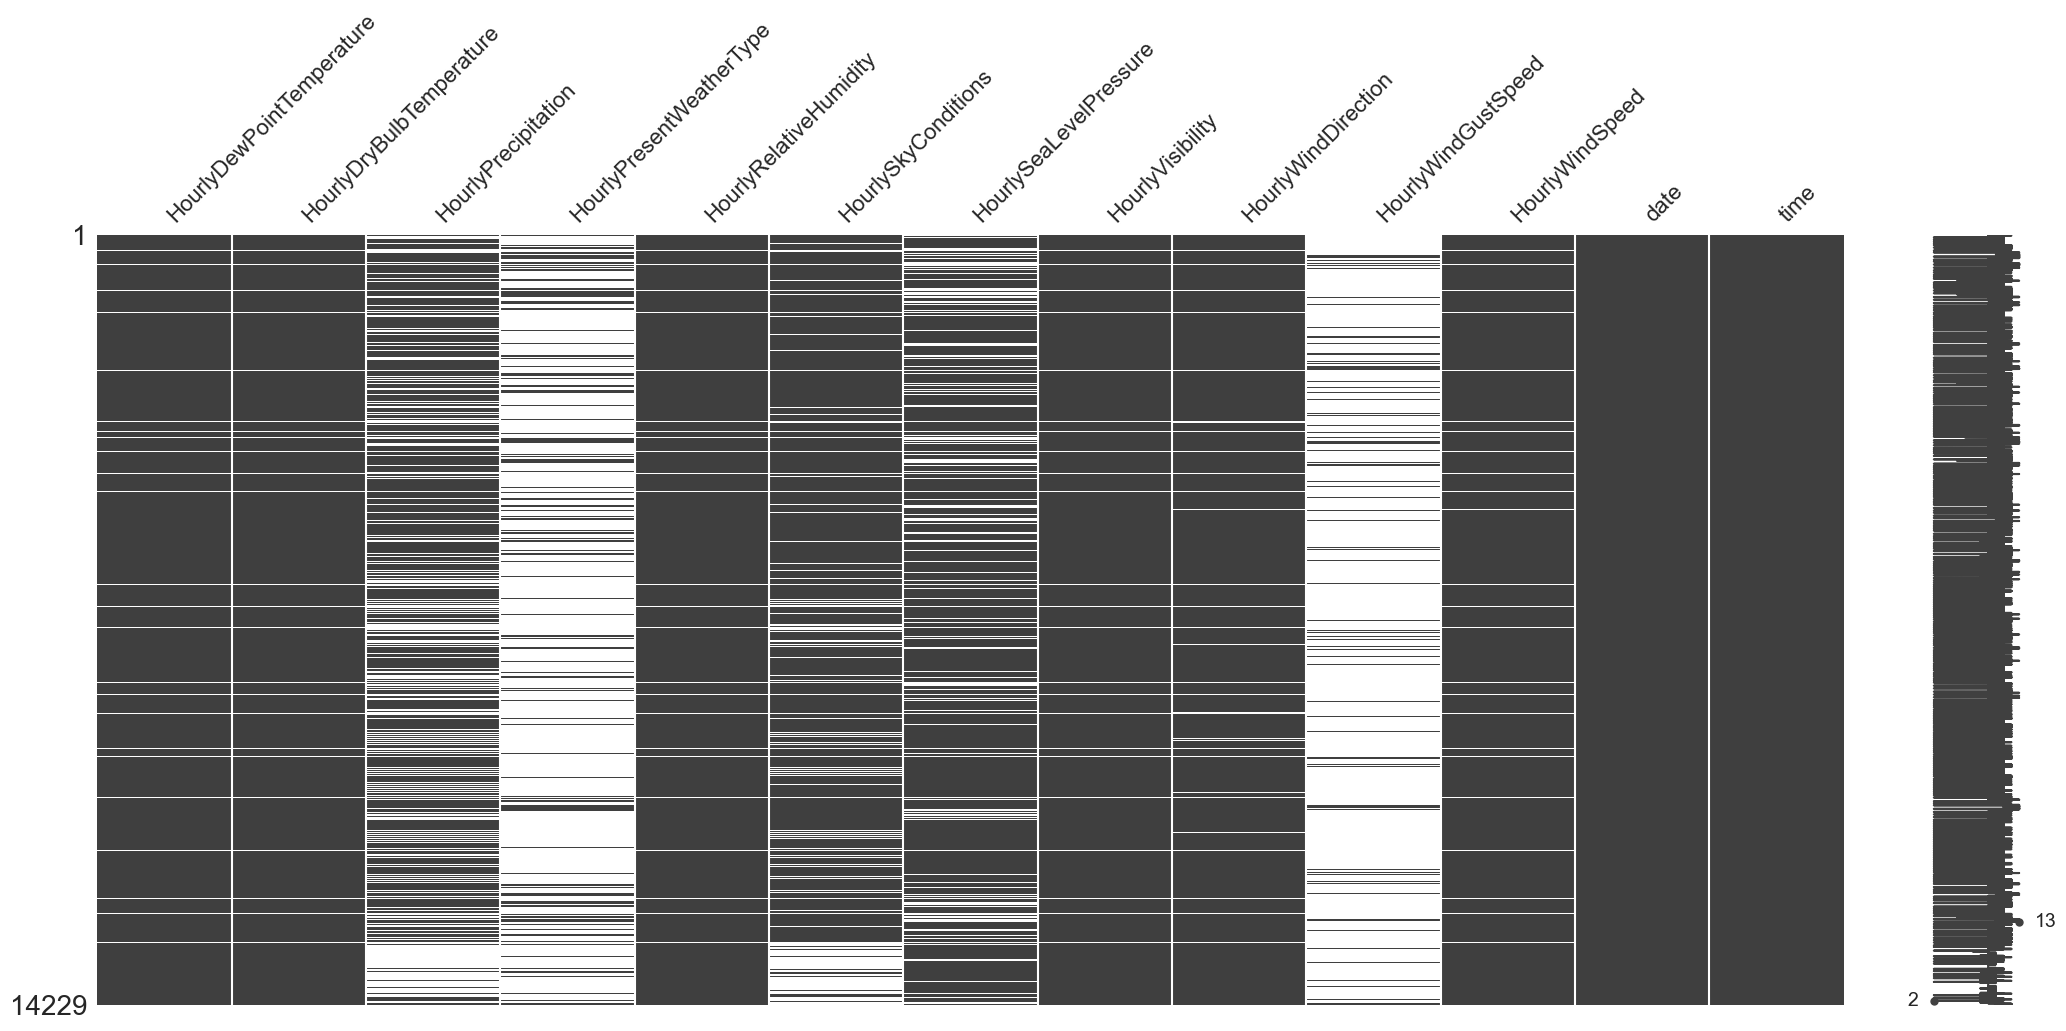

In [151]:
print(msno.matrix(df))

In [152]:
# NaN values are basically zero values
df["HourlyPrecipitation"] = df["HourlyPrecipitation"].fillna(0)
df["HourlyWindGustSpeed"] = df["HourlyWindGustSpeed"].fillna(0)

In [153]:
df = df.set_index('date')

num_cols = [
    "HourlyDryBulbTemperature",
    "HourlyDewPointTemperature",
    "HourlyRelativeHumidity",
    "HourlyWindSpeed",
    "HourlyWindDirection",
    "HourlyVisibility",
    "HourlySeaLevelPressure"
]

# Interpolating
df[num_cols] = (
    df[num_cols]
    .interpolate(method="time")
    .ffill()
    .bfill()
)


C:\Users\Desmo\AppData\Local\Temp\ipykernel_10252\389546230.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .interpolate(method="time")


In [154]:
df["HourlySkyConditions"] = (
    df["HourlySkyConditions"]
    .fillna("UNKNOWN")
)

In [155]:
df["HourlyPresentWeatherType"] = (
    df["HourlyPresentWeatherType"]
    .fillna("NONE")
)


In [156]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14229 entries, 2024-01-01 00:56:00 to 2024-12-31 23:56:00
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HourlyDewPointTemperature  14229 non-null  float64
 1   HourlyDryBulbTemperature   14229 non-null  object 
 2   HourlyPrecipitation        14229 non-null  object 
 3   HourlyPresentWeatherType   14229 non-null  object 
 4   HourlyRelativeHumidity     14229 non-null  float64
 5   HourlySkyConditions        14229 non-null  object 
 6   HourlySeaLevelPressure     14229 non-null  object 
 7   HourlyVisibility           14229 non-null  object 
 8   HourlyWindDirection        14229 non-null  object 
 9   HourlyWindGustSpeed        14229 non-null  float64
 10  HourlyWindSpeed            14229 non-null  object 
 11  time                       14229 non-null  int32  
dtypes: float64(3), int32(1), object(8)
memory usage: 1.4+ MB
None


# Checking for dtypes on objects

## HourlyDryBulbTemperature

In [157]:
df['HourlyDryBulbTemperature'].unique()

array([34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 30.0, 29.0, 28.0, 31.0, 27.0,
       26.0, 32.0, 40.0, 44.0, 46.0, 43.0, 42.0, 41.0, 25.0, 33.0, 45.0,
       48.0, 49.0, 50.0, 51.0, 47.0, 52.0, 53.0, 21.0, 20.0, 19.0, 17.0,
       16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 18.0,
       22.0, 24.0, 23.0, 5.0, 4.0, 3.0, 54.0, 55.0, 57.0, 58.0, 59.0,
       61.0, 60.0, 56.0, 62.0, 63.0, 65.0, 64.0, 66.0, 67.0, 68.0, 69.0,
       71.0, 74.0, 75.0, 76.0, 72.0, 73.0, 70.0, 77.0, 78.0, 80.0, 81.0,
       79.0, 82.0, 84.0, 83.0, 85.0, 86.0, 87.0, 88.0, 90.0, 89.0, 91.0,
       92.0, 93.0, 94.0, 95.0, '89', '87', '86', '84', '83', '81', '80',
       '79', '78', '77', '76', '73', '72', '75', '82', '85', '74', '69',
       '70', '88', '90', '71', '91', '92', '93', '73s', '67', '66', '65',
       '64', '63', '68', '62', '94', '61', '59', '57', '58', '96', '98',
       '97', '95', '99', '101', '100', '60', '56', '54', '52', '51', '55',
       '53', '50', '49', '46', '44', '43', '41', 

In [158]:
# Replacing str with numeric values using regular expression
df["HourlyDryBulbTemperature"] = df["HourlyDryBulbTemperature"].where(
    ~df["HourlyDryBulbTemperature"].apply(lambda x: isinstance(x, str)),
    df["HourlyDryBulbTemperature"].str.replace(r"[a-zA-Z]", "", regex=True)
)

In [159]:
df['HourlyDryBulbTemperature'] = pd.to_numeric(df['HourlyDryBulbTemperature'])

In [160]:
df['HourlyDryBulbTemperature'].dtype

dtype('float64')

## HourlyPrecipitation

In [161]:
df['HourlyPrecipitation'].unique()

array(['0.00', 0, 'T', '0.01', '0.05', '0.09', '0.08', '0.10', '0.04',
       '0.03', '0.02', '0.16', '0.15', '0.11', '0.21', '0.19', '0.07',
       '0.13', '0.06', '0.14', '0.17', '0.20', '0.26', '0.01s', '0.18',
       '0.36', '0.24', '0.12', '0.29', '0.03s', '0.02s', '0.25', '0.28',
       '0.35', '0.49', '0.22', '0.23', '0.06s', '0.40', '0.41', '0.08s',
       '0.31', '0.42', '0.32', '0.52', '0.58', '0.27', '0.38', '0.68',
       '0.83', '0.90', '0.96', '0.98', '1.00', '0.30', '0.33', '0.64s',
       '0.84', '1.80', '0.15s', '0.55', '0.64', '0.74', '0.16s', '0.34',
       '0.54', '0.59', '0.75', '0.37', '0.50', '0.53', '0.56', '0.76'],
      dtype=object)

In [162]:
# Replacing str with numeric values using regular expression
df['HourlyPrecipitation'] = df['HourlyPrecipitation'].replace(['T'], 0)
df["HourlyPrecipitation"] = df["HourlyPrecipitation"].where(
    ~df["HourlyPrecipitation"].apply(lambda x: isinstance(x, str)),
    df["HourlyPrecipitation"].str.replace(r"[a-zA-Z]", "", regex=True)
)

df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'])


In [163]:
df['HourlyPrecipitation'].dtype

dtype('float64')

## HourlyPresentWeatherType

In [164]:
df['HourlyPresentWeatherType'].unique()

array(['NONE', '-SN:03 |SN |', '-RA:02 |RA |RA', '||RA', 'RA:02 |RA |RA',
       'RA:02 BR:1 |RA |RA', '-RA:02 BR:1 |RA |RA', 'UP:09 ||',
       '-DZ:01 |DZ |DZ', '-DZ:01 BR:1 |DZ |DZ', '||DZ',
       '-RA:02 SN:03 |RA RA SN |RA', '+RA:02 BR:1 |RA |RA',
       '+RA:02 |RA |RA', 'VCTS:7 -RA:02 |RA |RA', 'VCTS:7 RA:02 |RA |RA',
       '-SN:03 RA:02 |RA RA SN |RA', '|SN |', '-SN:03 BL:5 SN:03 |SN |',
       'BR:1 ||', '|DZ |RA', '-DZ:01 BC:3 FG:2 BR:1 |FG DZ |DZ', '|DZ |',
       '|FG DZ |', '|FG |', 'VCTS:7 +RA:02 BR:1 |RA |RA',
       'TS:7 -RA:02 |RA TS TS |RA', 'TS:7 +RA:02 BR:1 |RA TS |RA',
       'TS:7 RA:02 BR:1 |RA TS |RA', 'HZ:7 |FU |HZ', 'TS:7 |TS TS |',
       '|TS |', 'TS:7 RA:02 |RA TS TS |RA', 'PL:06 |PL |PL',
       '-SN:03 BR:1 |SN |', 'MI:1 FG:2 BR:1 |FG |', '||HZ',
       'TS:7 +RA:02 |RA TS TS |RA', '||TS', '-PL:06 RA:02 |RA PL |RA PL',
       '||FG', '|RA |RA', 'TS:7 -RA:02 |RA TS |RA',
       'TS:7 -RA:02 SQ:2 |SQ RA TS |RA', 'TS:7 +RA:02 |RA TS |RA',
       'TS:7 |TS

In [165]:
WEATHER_MAP = {
    "RA": "rain",        
    "SN": "snow",        
    "DZ": "drizzle",     
    "TS": "thunderstorm",
    "FG": "fog",       
    "BR": "mist",       
    "HZ": "haze",        
    "FU": "smoke",       
    "PL": "ice_pellets", 
    "GR": "hail",       
    "UP": "unknown",    
    "SQ": "squall",     
    "BC": "fog",      
    "MI": "fog",        
    "VC": "vicinity"   
}

In [166]:
def simplify_weather(raw):
    if raw in ["NONE", "", None]:
        return "clear"

    found = set()

    for code, label in WEATHER_MAP.items():
        if re.search(rf"\b{code}\b", raw):
            found.add(label)

    if not found:
        return "other"

    # priority
    priority = ["thunderstorm", "snow", "rain", "fog", "mist", "haze"]

    for p in priority:
        if p in found:
            return p

    return "_".join(sorted(found))


In [167]:
df['HourlyWeatherType'] = df['HourlyPresentWeatherType'].apply(simplify_weather)

In [168]:
df['HourlyWeatherType'].unique()

array(['clear', 'snow', 'rain', 'unknown', 'drizzle', 'mist', 'fog',
       'thunderstorm', 'haze', 'ice_pellets', 'other', 'smoke'],
      dtype=object)

In [169]:
merge_weather_map = {
    'mist': 'fog',
    'haze': 'fog',
    'smoke': 'fog',
    'drizzle': 'rain',
    'ice_pellets': 'snow',
    'unknown': 'clear'
}

df['HourlyWeatherType'] = df['HourlyWeatherType'].replace(merge_weather_map)

In [170]:
df['HourlyWeatherType'].value_counts(normalize=True)

HourlyWeatherType
clear           0.819594
rain            0.116031
thunderstorm    0.023895
fog             0.021997
snow            0.017429
other           0.001054
Name: proportion, dtype: float64

In [171]:
df = df.drop(columns=['HourlyPresentWeatherType'], axis=1)

## HourlySkyConditions

In [172]:
df['HourlySkyConditions'].unique()

array(['SCT:04 25 BKN:07 50', '26', 'OVC:08 45', ...,
       'FEW:02 6 SCT:04 28 OVC:08 41', 'SCT:04 8 OVC:08 44',
       'SCT:04 7 OVC:08 42'], shape=(4546,), dtype=object)

In [173]:
import re

SKY_MAP = {
    "CLR": "clear",
    "SKC": "clear", 
    "FEW": "few",
    "SCT": "scattered",
    "BKN": "broken",
    "OVC": "overcast",
}

def simplify_sky(raw):
    if raw is None:
        return "unknown"
    raw = str(raw).strip()
    if raw == "" or raw == "UNKNOWN":
        return "unknown"

    # priority: overcast > broken > scattered > few > clear
    priority = ["OVC", "BKN", "SCT", "FEW", "CLR", "SKC"]

    for p in priority:
        if re.search(rf"\b{p}\b", raw):
            return SKY_MAP.get(p, "other")

    # if nums '26' / '15' / '300'
    if re.fullmatch(r"\d+", raw):
        return "other"   # or "unknown"

    return "other"

df["HourlySkyCondit"] = df["HourlySkyConditions"].apply(simplify_sky)

In [174]:
df["HourlySkyCondit"].unique()

array(['broken', 'other', 'overcast', 'unknown', 'scattered', 'few',
       'clear'], dtype=object)

In [175]:
df["HourlySkyCondit"].value_counts(normalize=True)

HourlySkyCondit
overcast     0.272683
unknown      0.183358
broken       0.173589
other        0.118280
few          0.106051
clear        0.080540
scattered    0.065500
Name: proportion, dtype: float64

In [176]:
sky_cond_map = {
    'few': 'partly_cloudy',
    'scattered': 'partly_cloudy',
    'broken': 'cloudy',
    'overcast': 'cloudy',
    'unknown': 'clear'
}

In [177]:
df['HourlySkyCondit'] = df['HourlySkyCondit'].replace(sky_cond_map)

In [178]:
df = df.drop(columns=['HourlySkyConditions'], axis=1)

## HourlySeaLevelPressure

In [179]:
df['HourlySeaLevelPressure'].unique()

array(['30.15', '30.16', '30.17', '30.18', '30.19', '30.21', '30.23',
       '30.24', '30.27', '30.30', '30.29', '30.28', '30.32', '30.33',
       '30.34', '30.35', '30.36', '30.26', '30.25', '30.22', '30.14',
       '30.13', '30.12', '30.08', '30.06', '30.04', '30.03', '30.11',
       '30.20', '30.31', '30.10', '30.05', '29.99', '29.96', '29.92',
       '29.90', '29.87', '29.82', '29.80', '29.76', '29.77', '29.75',
       '29.74', '29.73', '29.71', '29.70', '29.68', '29.66', '29.72',
       '29.78', '29.79', '29.81', '29.84', '29.86', '29.91', '29.95',
       '30.02', '30.07', '30.37', '29.98', '29.65', '29.59', '29.52',
       '29.45', '29.38', '29.37', '29.33', '29.31', '29.19', '29.16',
       '29.10', '29.09', '29.08', '29.13', '29.20', '29.21', '29.22',
       '29.25', '29.27', '29.30', '29.35', '29.40', '29.51', '29.54',
       '29.58', '29.64', '29.69', '29.85', '29.94', '29.97', '29.63',
       '29.56', '29.50', '29.41', '29.29', '29.15s', '29.16s', '29.24',
       '29.28', '2

In [180]:
df["HourlySeaLevelPressure"] = (
    df["HourlySeaLevelPressure"]
    .str.replace(r"[a-zA-Z]", "", regex=True))

In [181]:
df['HourlySeaLevelPressure'] = pd.to_numeric(df['HourlySeaLevelPressure'])

## HourlyVisibility

In [182]:
df['HourlyVisibility'].unique()

array(['10.00', '9.94', '9.00', '8.70', '8.00', '6.00', '7.00', '6.84',
       '5.00', '4.97', '2.50', '3.00', '4.00', '3.73', '2.00', '1.75',
       '2.98', '2.49', '5.59', '1.00', '1.99', '1.50', '1.25', '1.74',
       '1.49', '0.75', '7.46', '2.00V', '0.99', '1.24', '0.50', '0.25',
       '2.50V', '0.00', '0.12', '1.25V', '10.00s'], dtype=object)

In [183]:
df["HourlyVisibility"] = (
    df["HourlyVisibility"]
    .str.replace(r"[a-zA-Z]", "", regex=True))

In [184]:
df['HourlyVisibility'] = pd.to_numeric(df['HourlyVisibility'])

## HourlyWindDirection

In [185]:
df['HourlyWindDirection'].unique()

array(['270', '290', '280', '300', '310', '320', '340', '240', '220',
       'VRB', '260', '250', '230', '210', '200', '000', '180', '170',
       '110', '120', '130', '160', '330', '360', '010', '350', '020',
       '030', '100', '090', '060', '070', '040', '050', '150', '080',
       '140', '190'], dtype=object)

In [186]:
def encode_wind_direction(val):
    # variable wind
    if val == "VRB":
        return np.nan, np.nan, 1

    if val is None or val == "":
        return np.nan, np.nan, 0

    try:
        deg = int(val)
    except ValueError:
        return np.nan, np.nan, 0

    # calm wind
    if deg == 0:
        return 0.0, 0.0, 0

    rad = np.deg2rad(deg)
    return np.sin(rad), np.cos(rad), 0

In [187]:
df["wind_dir_sin"], df["wind_dir_cos"], df["wind_dir_vrb"] = zip(
    *df["HourlyWindDirection"].apply(encode_wind_direction)
)

In [188]:
# missing flag (not VRB)
df["wind_dir_missing"] = (
    df["wind_dir_sin"].isna() &
    (df["wind_dir_vrb"] == 0)
).astype(int)

# replace NaN
df["wind_dir_sin"] = df["wind_dir_sin"].fillna(0.0)
df["wind_dir_cos"] = df["wind_dir_cos"].fillna(0.0)

In [189]:
df = df.drop(columns=['HourlyWindDirection', "wind_dir_missing"], axis=1)

## HourlyWindSpeed

In [190]:
df['HourlyWindSpeed'].unique()

array([10.0, 11.0, 9.0, 8.0, 7.0, 5.0, 6.0, 3.0, 0.0, 15.0, 14.0, 16.0,
       13.0, 18.0, 17.0, 26.0, 21.0, 24.0, 30.0, 28.0, 22.0, 23.0, 25.0,
       20.0, 32.0, 31.0, 29.0, 40.0, 38.0, 33.0, '7', '8', '9', '5', '6',
       '3', '10', '0', '11', '16', '14', '13', '36', '20', '29', '23',
       '31', '17', '18', '15', '21', '26', '22', '24', '28', '30', '25',
       '3s'], dtype=object)

In [191]:
# Replacing str with numeric values using regular expression
df["HourlyWindSpeed"] = df["HourlyWindSpeed"].where(
    ~df["HourlyWindSpeed"].apply(lambda x: isinstance(x, str)),
    df["HourlyWindSpeed"].str.replace(r"[a-zA-Z]", "", regex=True)
)

In [192]:
df['HourlyWindSpeed'] = pd.to_numeric(df['HourlyWindSpeed'])

In [193]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14229 entries, 2024-01-01 00:56:00 to 2024-12-31 23:56:00
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HourlyDewPointTemperature  14229 non-null  float64
 1   HourlyDryBulbTemperature   14229 non-null  float64
 2   HourlyPrecipitation        14229 non-null  float64
 3   HourlyRelativeHumidity     14229 non-null  float64
 4   HourlySeaLevelPressure     14229 non-null  float64
 5   HourlyVisibility           14229 non-null  float64
 6   HourlyWindGustSpeed        14229 non-null  float64
 7   HourlyWindSpeed            14229 non-null  float64
 8   time                       14229 non-null  int32  
 9   HourlyWeatherType          14229 non-null  object 
 10  HourlySkyCondit            14229 non-null  object 
 11  wind_dir_sin               14229 non-null  float64
 12  wind_dir_cos               14229 non-null  float64
 13  wind_dir_vr

# Adding key column for merge

In [194]:
df['airport'] = 'SDF'
df['date'] = df.index.date
weather_data_df = df.copy()

<Axes: >

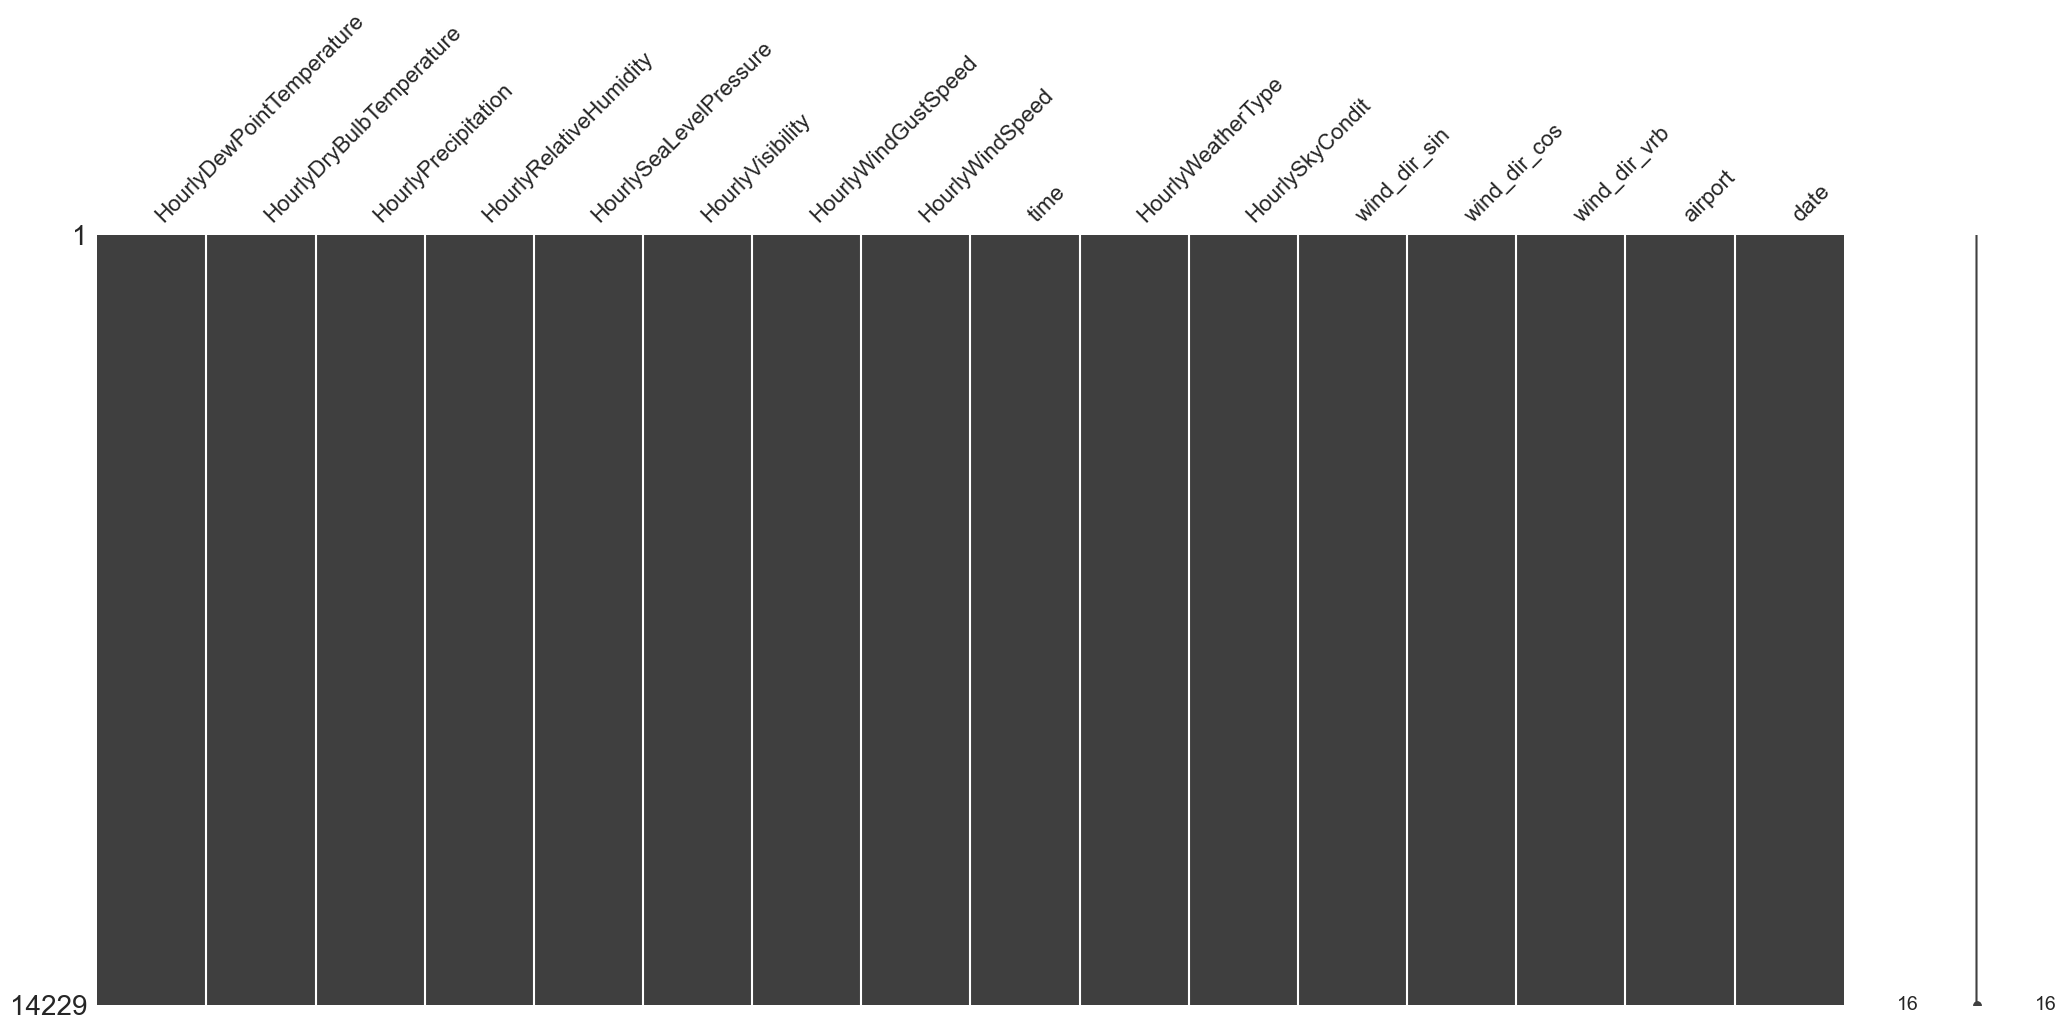

In [48]:
msno.matrix(weather_data_df)

In [49]:
weather_data_df.drop_duplicates()
print(weather_data_df.shape)

(14229, 16)


In [50]:
#weather_data_df.to_csv("data/weather_data.csv", index=False)